In [4]:
%load_ext autoreload
%autoreload 2


In [5]:
# external modules
import numpy as np
import pandas as pd
from pathlib import Path


# Observation

In [6]:
# local module for working with spectral data
import spectra


## Load reflectance data

<Axes: title={'center': 'Processed Lab Spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

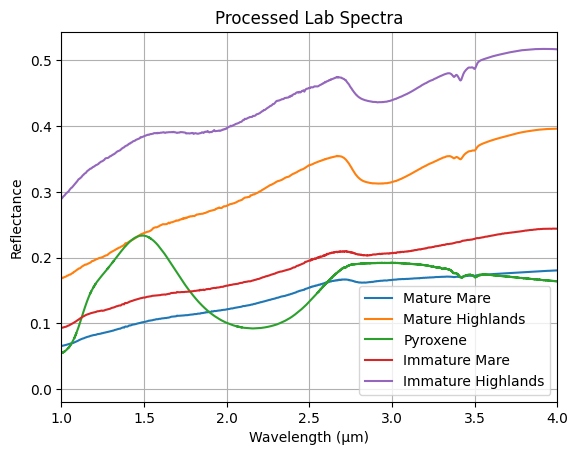

In [7]:
# Import reflectance spectra (processed to remove hydration and organics)
samples = {
    'Mature Mare': Path('../data/Mare_70181_Spectra.txt'),
    'Mature Highlands': Path('../data/Highlands_62231_Spectra.txt'),
    'Pyroxene': Path('../data/Apollo15Sample15555ReddishBrownPyroxeneB.txt'),
    'Immature Mare': Path('../data/Mare_71061_Spectra.txt'),
    'Immature Highlands': Path('../data/Highlands_61221_Spectra.txt'),
}

lab_spectra = []
for name, path in samples.items():
    lab_spectra.append(
        spectra.spectrum_from_file(path, name, header=2, delimiter='\t')
    )

endmember_spectra = pd.concat(lab_spectra, axis=1)

# Figure 1a
endmember_spectra.plot(
    title='Processed Lab Spectra',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
    xlim=(1, 4),
)


In [8]:
# Temperature of step-heating experiment in degrees Celsius
temperature = [650, 700, 750, 800]
# Total water measured from step-heating experiments in ppm
water_ppm = [1522, 762, 176, 22]

experiments = zip(temperature, water_ppm)


<Axes: title={'center': 'Heated MORB spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

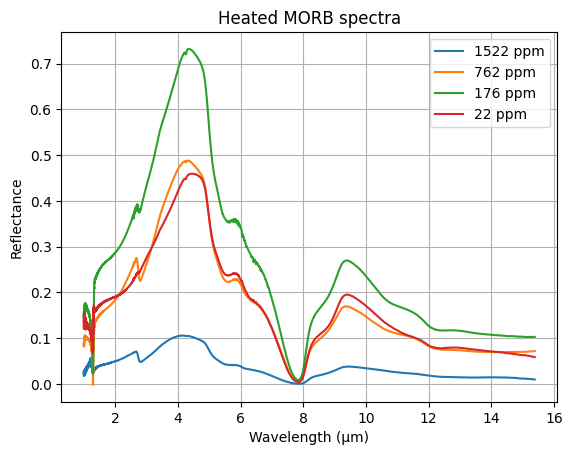

In [9]:
# MORB step-wise heating spectra
imported_reflectances = []
for deg_c, ppm in experiments:
    MORB_spectrum = spectra.spectrum_from_file(
            Path(f"../data/{deg_c}^oC.csv"),
            name=f'{ppm} ppm')
    MORB_spectrum.index = 1e4 / MORB_spectrum.index  # 1/cm to microns
    MORB_spectrum = MORB_spectrum / 100  # percent to decimal
    
    # since we converted frequency to wavelength, need to resort data
    MORB_spectrum = MORB_spectrum.sort_index()
    imported_reflectances.append(MORB_spectrum)

heated_MORB_spectra = pd.concat(imported_reflectances, axis=1)
heated_MORB_spectra.plot(
    title='Heated MORB spectra',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
)


<Axes: title={'center': 'MORB D38A low wavelengths'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

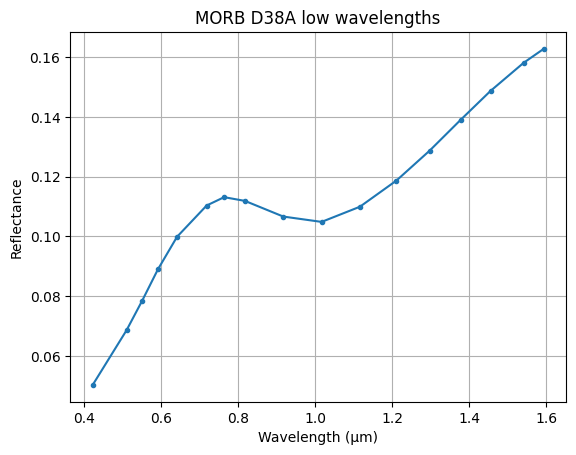

In [19]:
# Low wavelength portion of MORB spectrum (<1.5 microns)
MORB_D38A_LowLam = spectra.spectrum_from_file(
    Path("../data/Morb_D38A_Low_wavelength.txt"),
    name='MORB D38A low wavelengths',
)
MORB_D38A_LowLam.plot(
    title='MORB D38A low wavelengths',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    marker='.',
)


<Axes: title={'center': 'Normalized MORB spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

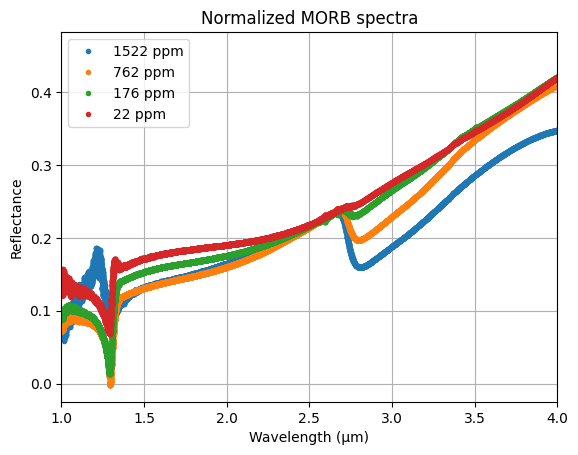

In [25]:
# Normalize all MORB spectra to the reflectance at 2.6 microns at the
# lowest water amount and highest temperature (22 ppm, 800 C)
scale_factor = spectra.get_normalization_factor(
    heated_MORB_spectra['22 ppm'], 2.6)
normalized_spectra = pd.DataFrame()
for spectrum in heated_MORB_spectra.columns:
    MORB_spectrum = heated_MORB_spectra[spectrum]
    
    norm_factor = spectra.get_normalization_factor(MORB_spectrum, 2.6)
    norm_spectrum = MORB_spectrum * (scale_factor / norm_factor)
    normalized_spectra[spectrum] = norm_spectrum

normalized_spectra.plot(
    title='Normalized MORB spectra',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
    xlim=(1, 4),
    marker='.',
    linewidth=0,
)


<Axes: title={'center': 'Simplified MORB spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

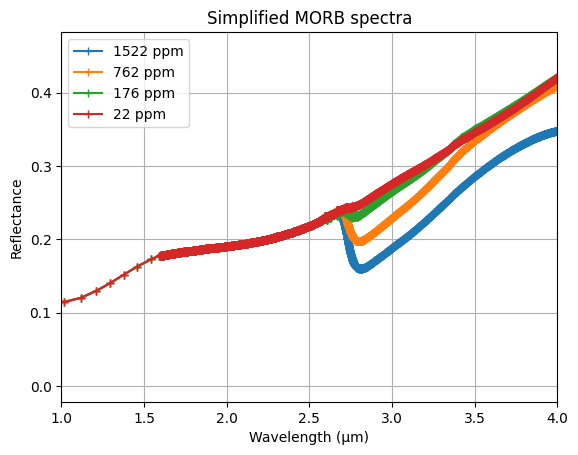

In [26]:
# Replace spectrum below 2.6 micron with 650C reflectance
# to isolate 3 micron feature changes and stitch in low wavelengths
mid_spectrum = normalized_spectra['22 ppm'].loc[
    MORB_spectrum.index < 2.6]
mid_spectrum = mid_spectrum.loc[mid_spectrum.index > 1.6]

# normalize lower spectrum to meet up with the rest of the spectrum
stitch_factor = spectra.get_normalization_factor(mid_spectrum, 1.6) / \
                spectra.get_normalization_factor(MORB_D38A_LowLam, 1.6)
lower_spectrum = MORB_D38A_LowLam * stitch_factor

simple_spectra = pd.DataFrame()
for spectrum in normalized_spectra.columns:
    MORB_spectrum = normalized_spectra[spectrum]
    unified_spectrum = mid_spectrum.combine_first(lower_spectrum)
    upper_spectrum = normalized_spectra[spectrum].loc[
        normalized_spectra.index > 2.6]

    simple_spectra[spectrum] = unified_spectrum.combine_first(upper_spectrum)

simple_spectra.plot(
    title='Simplified MORB spectra',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
    xlim=(1, 4),
    marker='+'
)


<Axes: title={'center': 'Full MORB spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

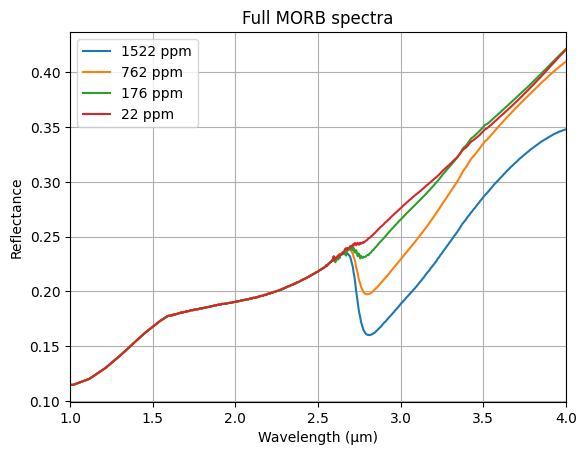

In [28]:

# define wavelength range and spacing for simulations as
# 1-4 micron at 5nm intervals
WLS = np.linspace(1, 4, 601)

# interpolate along our sampling grid of interest
interpolated_spectra = simple_spectra.apply(
    spectra.interpolate_series, args=[WLS], axis=0)


# Figure 1b
interpolated_spectra.plot(
    title='Full MORB spectra',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
    xlim=(1, 4),
)


## Calculate SSA using Hapke Model

Use Hapke model to convert from laboratory reflectance to single
scattering albedo using reflectance and scattering asymmetry
factor (p) of 0.81 (see manuscript for details on Hapke model)

In [14]:
from functools import partial

# local module for hapke model
import hapke


<Axes: title={'center': 'Estimated MORB Single-Scattering Albedo'}, xlabel='Wavelength (μm)', ylabel='SSA'>

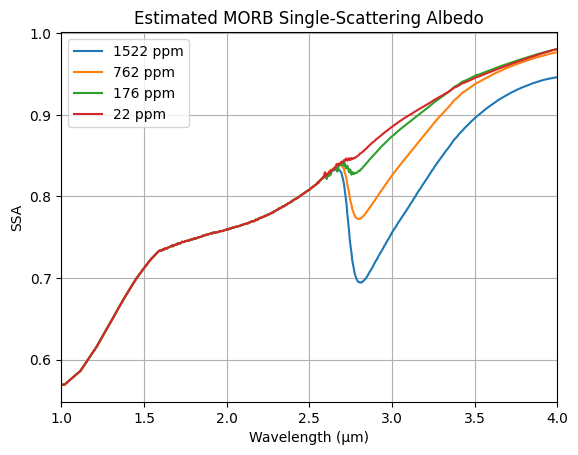

In [15]:
hapke_model = partial(hapke.ssa_from_reflectance, 
    asymmetry_factor = 0.81,
    emission_angle = 0,
    incident_angle = 30,
    phase_angle = 30,
    filling_factor = 0.41,
    initial_guess = 0.5
)
ssa_MORB = pd.DataFrame()
for ppm in interpolated_spectra:
    ssa_MORB[ppm] = interpolated_spectra[ppm].apply(hapke_model)

ssa_MORB.plot(
    title='Estimated MORB Single-Scattering Albedo',
    xlabel='Wavelength (μm)',
    ylabel='SSA',
    grid=True,
    legend=True,
    xlim=(1, 4),
)


<Axes: >

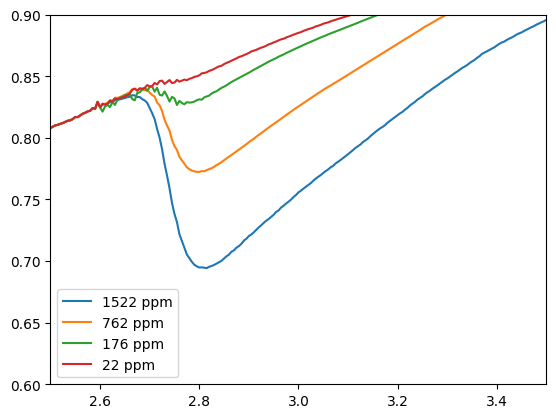

In [16]:
ssa_MORB.plot(xlim=(2.5,3.5), ylim=(.6,.9))


In [17]:
# set the total number of simulations to run
num_spectra = 100
